# Тестовое задание Аналитика данных
ЗеленыйМагазин — онлайн-сервис по доставке продуктов.
У нас есть доступ к базе со срезом транзакций. 
### Задание:
Найти все интересные инсайты и представить их в любом удобном виде.

Важная проблема бизнеса в ненайденных товарах: Клиент заказывает товары, но они заканчиваются в магазине к моменту начала сборки. Пользователи, очевидно, очень недовольны таким опытом:


### Структура базы данных

**orders**   
`Id` - id заказа  
`created_at` - timestamp создания заказа на сайте  
`delivery_window_id` - id слота доставки  
`item_total` - Сумма всех товаров в корзине (средний чек)  
`promo_total` - Сумма промо-кода на товары в корзине  
`cost` - Изначальная стоимость доставки  
`total_cost` - Финальная стоимость доставки (отличается, если был применен промо-код на доставку. Если промокода не было, то cost=total_cost)  
`ship_address_id` - id адреса доставки (ключ к addresses.id)  
`shipped_at` - timestamp доставки заказа  
`state` - состояние доставки (shipped, canceled и тд)  
`store_id` - id магазина  
`total_quantity` - Количество единиц товара  
`total_weight` - Вес заказа , г.  
`user_id` - id пользователя  

**delivery_windows**  
`id` - id слота доставки (ключ к orders.delivery_window_id)  
`starts_at` - timestamp начала слота доставки  
`ends_at` - timestamp конца слота доставки  
`store_id` - ID магазина  

**stores**  
`id` - ID магазина   
`city` - ID города  
`retailer_id` - ID ритейлера  

**addresses**  
`id` - ID адреса (ключ к orders.ship_address_id)  
`lat` - latitude  
`lon` - longitude  
  
**replacements**  
`item_id` - id товара, который был заменен  
`order_id` - id заказа, в котором была замена  
`state` - статус (замена)  

**cancellations**  
`item_id` - id товара, который был отменен  
`order_id` - id заказа, в котором была отмена  
`state` - статус (отмена)  

## Оглавление 
<a href = #connect>Подключение и выгрузка данных</a>  
<a href = #eda>Исследовательский анализ данных</a>  
- <a href = #product_metrics>Метрики продукта</a>  
- <a href = #delivery_order>Курьерская доставка и вес заказа</a>  
- <a href = #cities_retailers>Города и ритейлеры</a>  
- <a href = #return_replace>Возврат и замена</a>  
- <a href = #cohort_analysis>Когортный анализ</a> 

<a href = #presentation>Презентация</a>  
<a href = #conclusions>Выводы</a>  

## Подключимся и выгрузим данные 
<div id = connect></div>

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
connection_string = ('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
                    host = host,
                    port=port,
                    dbname=dbname,
                    sslmode=sslmode,
                    user=user,
                    password=password
                ))
engine = create_engine(connection_string, connect_args={'sslmode':sslmode})


In [3]:
query = '''
SELECT *
FROM addresses
'''
addresses = pd.io.sql.read_sql(query, con = engine)

In [4]:
addresses.duplicated().sum()

17660

In [5]:
addresses[addresses.duplicated()].head()

,lat,lon,id,elevator,floor
4379,55.815355,37.641164,295968,passenger,4
4436,55.844109,37.576927,575872,None,1
5677,55.844109,37.576927,575872,None,1
7644,55.870760,37.681005,726462,passenger,7
8880,55.844109,37.576927,575872,None,1


In [6]:
addresses.query('id==295968')

,lat,lon,id,elevator,floor
2927,55.815355,37.641164,295968,passenger,4
4379,55.815355,37.641164,295968,passenger,4


У нас есть 17660 дублей в таблице adresses, дублирующие записи добавляются не подряд и имеют одинаковые id. Возможно, наша проблема в базе или при редактировании адреса, но не изменении его, мы все равно добавляем запись в базу с прежним идентификатором. Стоит проверить алгоритм добавления нового адреса. 

Пока будем объединять таблицы, взяв уникальные индексы в таблице адресов. 

In [7]:
query = '''
SELECT orders.id,
        created_at,
        delivery_window_id,
        item_total,
        promo_total,
        cost,
        total_cost,
        ship_address_id,
        shipped_at,
        state,
        orders.store_id,
        total_quantity,
        total_weight,
        user_id, 
        starts_at,
        ends_at,
        city, 
        retailer_id,
        lat,
        lon
FROM orders
LEFT JOIN delivery_windows ON orders.delivery_window_id = delivery_windows.id
LEFT JOIN stores ON orders.store_id = stores.id
LEFT JOIN 
(SELECT DISTINCT(id),
        lat, lon
FROM addresses) adress_table
ON orders.ship_address_id = adress_table.id
'''
data = pd.io.sql.read_sql(query, con = engine)

Отдель выгрузим логи таблиц отмены и замены товаров

In [8]:
query = '''
SELECT *
FROM replacements
UNION ALL
SELECT *
FROM cancellations
'''
changed_status_products = pd.io.sql.read_sql(query, con = engine)

In [9]:
changed_status_products.head()

,order_id,item_id,state
0,480785,6466916,replaced
1,480785,6466940,replaced
2,480785,6466778,replaced
3,480785,6466825,replaced
4,480786,7261201,replaced


In [10]:
changed_status_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691849 entries, 0 to 2691848
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   order_id  int64 
 1   item_id   int64 
 2   state     object
dtypes: int64(2), object(1)
memory usage: 61.6+ MB


In [11]:
data.head()

,id,created_at,delivery_window_id,item_total,promo_total,cost,total_cost,ship_address_id,shipped_at,state,store_id,total_quantity,total_weight,user_id,starts_at,ends_at,city,retailer_id,lat,lon
0,790854,2018-09-13 12:06:43,241673,1404,-401.78,299.0,299.0,59745,2018-09-13 14:03:06,shipped,12,9,4628,19516,2018-09-13 14:00:00,2018-09-13 16:00:00,1,1,55.763084,37.651359
1,821971,2018-09-29 08:57:35,254941,6425,0.00,546.0,546.0,80438,2018-09-29 19:38:55,shipped,8,63,23764,27392,2018-09-29 19:00:00,2018-09-29 21:00:00,1,1,55.808956,37.718327
2,1178550,2019-03-04 07:39:34,424546,1781,0.00,299.0,299.0,91949,2019-03-08 07:43:00,shipped,12,20,14260,8288,2019-03-08 07:00:00,2019-03-08 09:00:00,1,1,55.747809,37.592644
3,915556,2018-11-12 10:33:33,298856,13763,0.00,1288.0,1288.0,118237,2018-11-12 16:00:00,shipped,14,87,43799,39813,2018-11-12 14:00:00,2018-11-12 16:00:00,1,1,55.652689,37.475729
4,2672994,2019-10-09 10:37:55,768561,4146,0.00,249.0,0.0,128049,2019-10-09 19:51:16,shipped,9,15,10435,41278,2019-10-09 20:00:00,2019-10-09 22:00:00,1,1,55.905464,37.579945


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720433 entries, 0 to 720432
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  720433 non-null  int64         
 1   created_at          720433 non-null  datetime64[ns]
 2   delivery_window_id  720433 non-null  int64         
 3   item_total          720433 non-null  int64         
 4   promo_total         720433 non-null  float64       
 5   cost                720433 non-null  float64       
 6   total_cost          720433 non-null  float64       
 7   ship_address_id     720433 non-null  int64         
 8   shipped_at          720433 non-null  datetime64[ns]
 9   state               720433 non-null  object        
 10  store_id            720433 non-null  int64         
 11  total_quantity      720433 non-null  int64         
 12  total_weight        720433 non-null  int64         
 13  user_id             720433 no

Возникли ли ошибки и есть ли полные дубли в датасете

In [13]:
data.isna().sum()

id                     0
created_at             0
delivery_window_id     0
item_total             0
promo_total            0
cost                   0
total_cost             0
ship_address_id        0
shipped_at             0
state                  0
store_id               0
total_quantity         0
total_weight           0
user_id                0
starts_at              4
ends_at                4
city                   0
retailer_id            0
lat                   46
lon                   46
dtype: int64

In [14]:
data[data.lat.isna()].head()

,id,created_at,delivery_window_id,item_total,promo_total,cost,total_cost,ship_address_id,shipped_at,state,store_id,total_quantity,total_weight,user_id,starts_at,ends_at,city,retailer_id,lat,lon
33770,1197180,2019-03-11 13:37:37,429038,10105,0.0,199.0,199.0,587064,2019-03-12 07:42:00,shipped,12,46,15299,102367,2019-03-12 07:00:00,2019-03-12 09:00:00,1,1,NaN,NaN
33771,2186449,2019-09-02 08:08:25,691049,2777,0.0,199.0,199.0,3108978,2019-09-02 15:28:45,shipped,63,38,19620,785404,2019-09-02 14:00:00,2019-09-02 16:00:00,2,1,NaN,NaN
56076,803347,2018-09-19 11:20:57,247389,2266,0.0,299.0,0.0,970416,2018-09-20 06:44:03,shipped,2,13,5075,33622,2018-09-20 06:00:00,2018-09-20 08:00:00,1,1,NaN,NaN
56077,761473,2018-08-28 10:45:56,229238,3746,0.0,299.0,299.0,644602,2018-08-29 07:38:59,shipped,12,9,2087,123176,2018-08-29 07:00:00,2018-08-29 09:00:00,1,1,NaN,NaN
135051,798735,2018-09-17 10:52:16,245013,1651,0.0,498.0,0.0,400864,2018-09-17 18:30:52,shipped,12,84,95380,75665,2018-09-17 20:00:00,2018-09-17 22:00:00,1,1,NaN,NaN


In [15]:
data[data.starts_at.isna()]

,id,created_at,delivery_window_id,item_total,promo_total,cost,total_cost,ship_address_id,shipped_at,state,store_id,total_quantity,total_weight,user_id,starts_at,ends_at,city,retailer_id,lat,lon
9509,4592295,2019-11-28 05:40:34,1013194,3585,0.0,299.0,299.0,5766772,2019-12-04 09:53:40,shipped,8,26,7505,276470,NaT,NaT,1,1,55.747079,37.857712
101028,5433668,2019-12-18 13:16:34,973730,1441,0.0,299.0,299.0,7133559,2019-12-18 21:30:56,shipped,14,13,7190,1835289,NaT,NaT,1,1,55.714121,37.395480
325689,5408981,2019-12-17 20:23:52,973326,11463,0.0,149.0,98.0,7103867,2019-12-18 21:10:49,shipped,1,20,12855,1829563,NaT,NaT,1,1,55.918005,37.710782
720253,5251456,2019-12-13 18:49:47,1242161,3697,0.0,249.0,158.0,6904295,2019-12-14 15:35:22,shipped,14,17,11404,46789,NaT,NaT,1,1,55.686341,37.569372


In [16]:
data.duplicated().sum()

0

Мы выгрузили данные и сформировали датасет, объединяющий таблицы заказов(orders), слотов доставок(delivery_windows), магазинов(stores) и адресов(adresses). Выгрузили отдельно логи таблиц отмены и замены товаров заказа, посмотрим как много нам приходится заменять товаров и поищем что-то общее у товаров отмены.   
Будем работать с 720432 заказов и 19 параметрами. Первичный анализ показал, что типы данных соответствуют заявленным и в датасете отсутствуют полные дубли, также в данных обнаружены пропуски, 46 значений отсутствует в колонках координат доставки(lat,lon), возможно, это объясняется последующим удалением адреса доставки пользователем. 4 пропуска в колонках интервала доставки (starts_at,ends_at) могут объясняться сбоем, либо удалением из базы таких интервалов. 

## Исследовательский анализ данных
<div id = eda></div>

In [17]:
print('Имеем данные заказов за период с {} по {}'.format(data.created_at.min(), data.created_at.max()))

Имеем данные заказов за период с 2018-08-26 00:05:41 по 2019-12-18 18:02:41


Создадим колонки даты без времни и других частей даты для дальнейшего анализа 

In [18]:
create_date_year = data.created_at.dt.date
data['create_date'] = data.created_at.dt.date
data['create_date_year'] = data.created_at.dt.year
data['create_date_month'] = data.created_at.dt.month
data['create_date_day'] = data.created_at.dt.day
data['create_date_week'] = data.created_at.dt.week
data['create_date_weekday'] = data.created_at.dt.weekday

### Метрики продукта
<div id = product_metrics></div>

In [19]:
dau = data.groupby('create_date').agg({'user_id': 'nunique'})
wau = data.groupby(['create_date_year', 'create_date_week']).agg({'user_id': 'nunique', 'create_date':'first'})
mau = data.groupby(['create_date_year', 'create_date_month']).agg({'user_id': 'nunique', 'create_date':'first'})
print('DAU = ', int(dau.mean()))
print('WAU = ', int(wau.mean()))
print('MAU = ', int(mau.mean()))

DAU =  1464
WAU =  9043
MAU =  27570


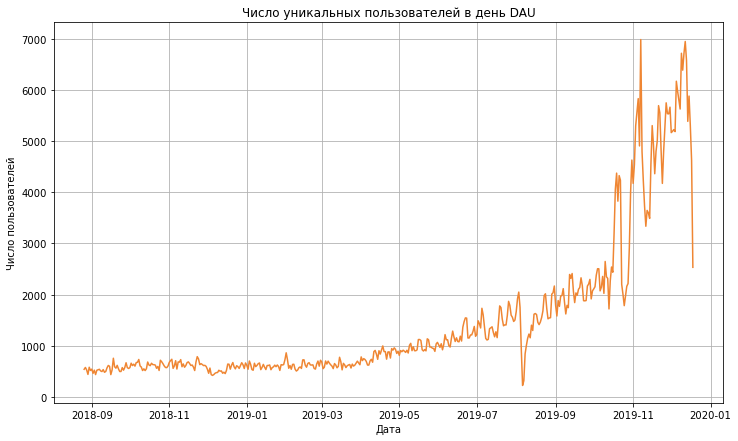

In [20]:
plt.figure(figsize=(12,7))
sns.lineplot(data = dau.reset_index(), x = 'create_date', y = 'user_id', color = '#ef8633')
plt.title('Число уникальных пользователей в день DAU')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число пользователей')
plt.show()

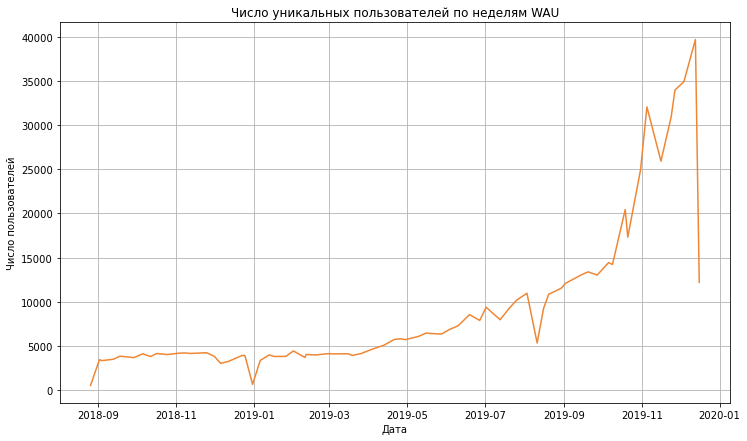

In [21]:
plt.figure(figsize=(12,7))
sns.lineplot(data = wau, x = 'create_date', y = 'user_id', color = '#ef8633')
plt.title('Число уникальных пользователей по неделям WAU')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число пользователей')
plt.show()

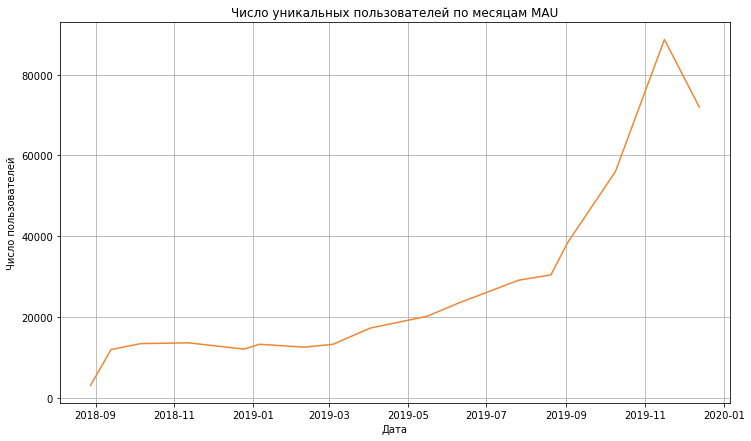

In [22]:
plt.figure(figsize=(12,7))
sns.lineplot(data = mau, x = 'create_date', y = 'user_id', color = '#ef8633')
plt.title('Число уникальных пользователей по месяцам MAU')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число пользователей')
plt.show()

Число уникальных пользователей растет от месяца к месяцу, значение первого и последнего месяца досчитаны не полностью, учитываем это. 
По неделям наблюдаем выбивающиеся снижения в январе(праздники) и августе, ноябре 2019 года. 

In [23]:
print('Средний чек равен {:.2f} рублей'.format(data.item_total.mean()))

Средний чек равен 4936.18 рублей


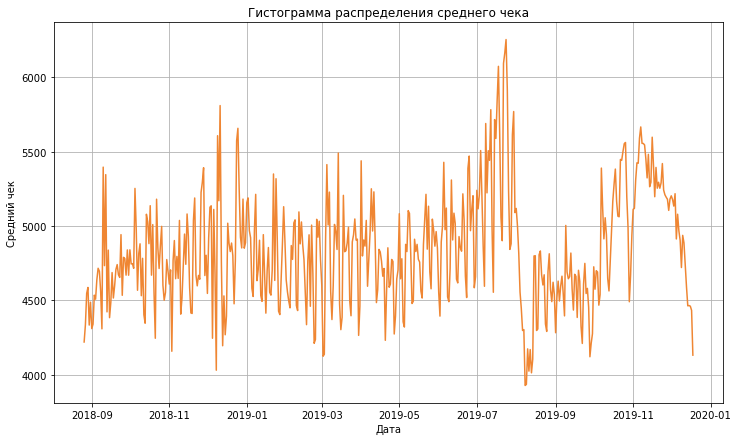

In [24]:
average_check = data.query("state == 'shipped'").groupby('create_date').agg({'item_total':'mean'}).reset_index()
plt.figure(figsize=(12,7))
sns.lineplot(data = average_check, x = 'create_date', y = 'item_total', color = '#ef8633')
plt.title('Гистограмма распределения среднего чека')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Средний чек')
plt.show()

По дневному графику видно, что мы около 10 дней фиксировали низкие значенияи с минимумом среднего чека 3926.78 рублей, позже значения немного отросли и зафиксировались на уровне 4500. Предполагаем, что в эти дни выросла стоимость доставки.

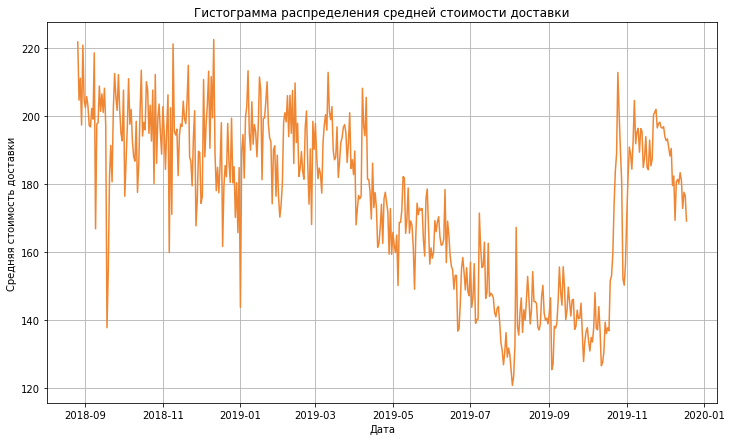

In [25]:
average_check = data.query("state == 'shipped'").groupby('create_date').agg({'total_cost':'mean'}).reset_index()
plt.figure(figsize=(12,7))
sns.lineplot(data = average_check, x = 'create_date', y = 'total_cost', color = '#ef8633')
plt.title('Гистограмма распределения средней стоимости доставки')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Средняя стоимость доставки')
plt.show()

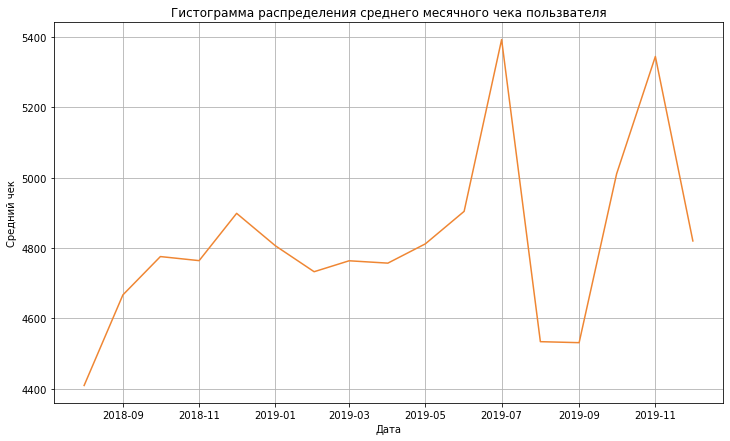

In [26]:
average_indicators_month = data.query("state == 'shipped'").\
                            groupby(['create_date_year','create_date_month'],
                                    as_index = False).agg({'item_total':['mean','count'],
                                                           'user_id':'nunique'})
average_indicators_month['date'] = pd.date_range(start='2018-08-01', end='2019-12-01', freq='MS')
plt.figure(figsize=(12,7))
sns.lineplot(data = average_indicators_month, x = 'date', y = ('item_total','mean'), color = '#ef8633')
plt.title('Гистограмма распределения среднего месячного чека пользвателя')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Средний чек')
plt.show()

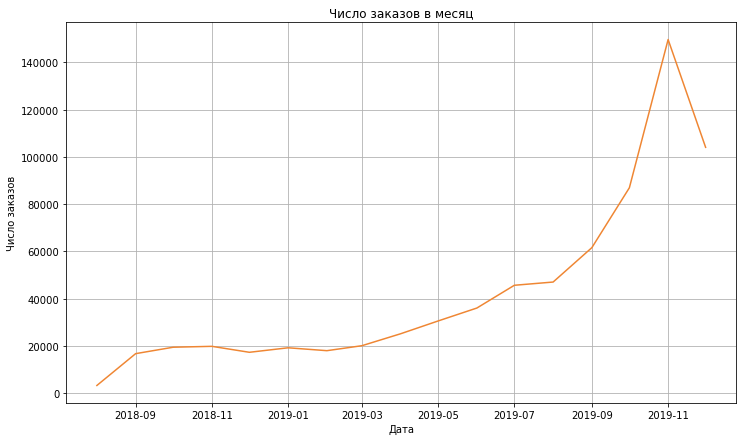

In [27]:
plt.figure(figsize=(12,7))
sns.lineplot(data = average_indicators_month, x = 'date', y = ('item_total','count'), color = '#ef8633')
plt.title('Число заказов в месяц')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число заказов')
plt.show()

In [28]:
print('Число заказов в сентябре 2018:', average_indicators_month[('item_total','count')][1])
print('Число заказов в ноябре 2019:', average_indicators_month[('item_total','count')][15])
print('Рост составляет {:.2%}'.format(average_indicators_month[('item_total','count')][15]
                                     / average_indicators_month[('item_total','count')][1]))

Число заказов в сентябре 2018: 16708
Число заказов в ноябре 2019: 149706
Рост составляет 896.01%


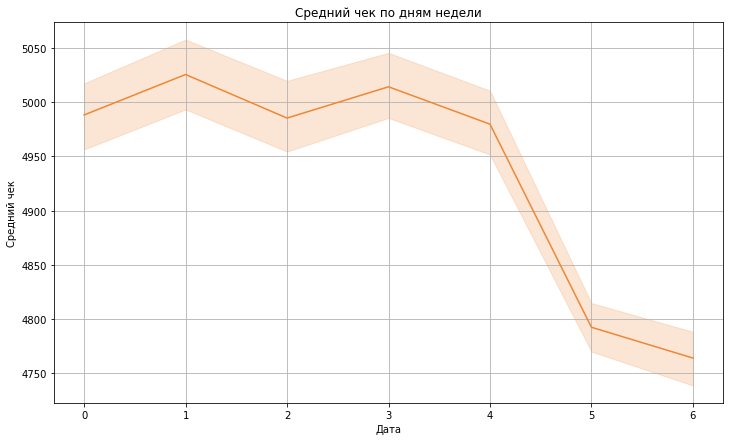

In [29]:
plt.figure(figsize=(12,7))
sns.lineplot(data = data, x = 'create_date_weekday', y = 'item_total', color = '#ef8633')
plt.title('Средний чек по дням недели')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Средний чек')
plt.show()

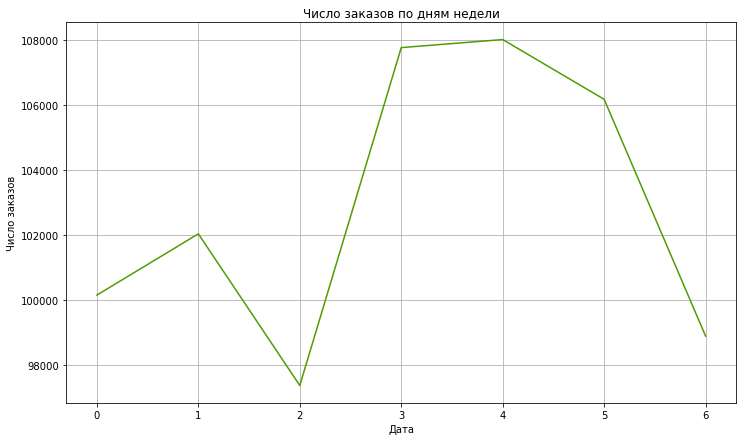

In [30]:
average_total_weekday = data.groupby('create_date_weekday').\
                                    agg({'item_total':['mean', 'count']}).reset_index()
plt.figure(figsize=(12,7))
sns.lineplot(data = average_total_weekday,
             x = 'create_date_weekday',
             y = ('item_total', 'count'),
             color = '#4f9b02')
plt.title('Число заказов по дням недели')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число заказов')
plt.show()

Наш средний чек имеет растущий тренд, но мы наблюдаем провал в августе-сентябре и дальнейший восстановительный рост. В то же время клиентов у сервиса становилось все больше, на графике мы видим снижение в последний месяц только потому, что оперируем данными только за его половину, до 18 числа.   
Средний чек сервиса 4936.18. По дневному графику видно, что мы около 10 дней фиксировали низкие значенияc с минимумом среднего чека 3926.78 рублей, позже значения немного отросли и зафиксировались на уровне 4500. Трудно сказать, является ли такая особенность сезонной, так как не имеем данных за прошлый год, но это может быть следствие сбоя или это результат конкретных решений в продукте. Из того, что значения не отросли до прежних максимумов, а зафиксировались в новом интервале, можем сказать, что резульат - следствие изменений в продукте.  
Предположили рост стоимости доставки, но это не подтвердилось, средняя стоимость доставки в этот период снижалась.
Средний чек снижается в период выходных(с 5000 до 4800 рублей). 
Максимальное число заказов получаем в четверг и пятницу(108000), минимальное в среду(около 98000) и воскресенье(98000). 

Число заказов сервиса стремительно растет, с сентября 2019 но ноябрб 2019 фиксируем рост 896%. 


Посмотрим теперь на показатели стоимости корзины пользователя в статике.

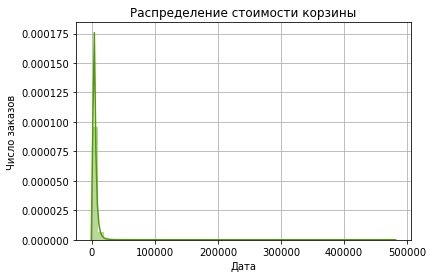

In [31]:
sns.distplot(data.item_total, color = '#4f9b02')
plt.title('Распределение стоимости корзины')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число заказов')
plt.show()

Имеем распределние с длинным хвостом, посмотрим основные показатели распределения

In [32]:
data.item_total.describe()

count    720433.000000
mean       4936.180057
std        4801.748586
min           0.000000
25%        2673.000000
50%        3964.000000
75%        5918.000000
max      481195.000000
Name: item_total, dtype: float64

In [33]:
item_quantile = data.item_total.quantile(.99)
item_quantile

19564.68000000005

Отфильтруем значения стоимости корзины по 99 персентилю и посмотрим на распределение

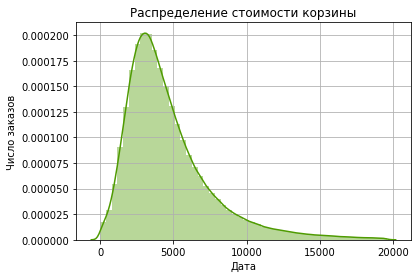

In [34]:
sns.distplot(data.query('item_total<@item_quantile').item_total, color = '#4f9b02')
plt.title('Распределение стоимости корзины')
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Число заказов')
plt.show()

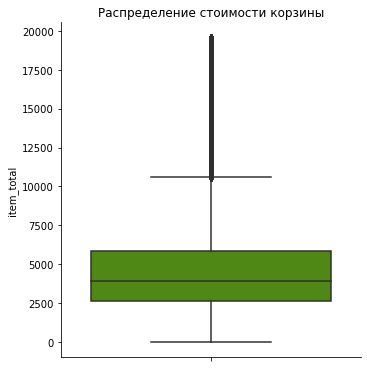

In [35]:
sns.catplot(data = data.query('item_total<@item_quantile'), y = 'item_total', kind = 'box', color = '#4f9b02')
plt.title('Распределение стоимости корзины')
plt.show()

In [36]:
data[data.item_total > item_quantile].item_total.describe()

count      7205.000000
mean      32668.620541
std       25645.160267
min       19565.000000
25%       21546.000000
50%       24927.000000
75%       32612.000000
max      481195.000000
Name: item_total, dtype: float64

Средний чек равен 4921.4, меданное значение 3951 рублей, имеем длинный хвост распределения. Считаем, что дорогие заказы являются еще и тяжелыми, посомтрим на это дальше и преложим варианты

### Курьерская доставка и вес заказа
<div id = delivery_order></div>

За сколько доставляются заказы

In [37]:
delta_ship = data.shipped_at - data.created_at
delta_ship.describe()

count                        720433
mean      4 days 08:20:19.602926294
std      14 days 17:10:28.389401646
min               -3 days +00:02:25
25%                 0 days 12:06:45
50%                 1 days 01:18:07
75%                 3 days 13:59:53
max               479 days 06:44:11
dtype: object

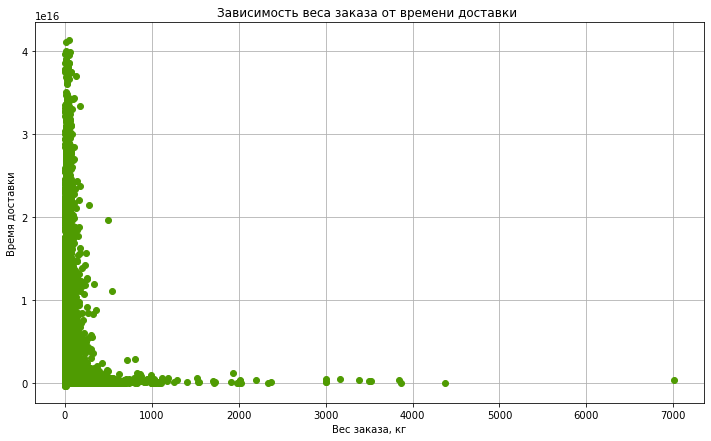

In [38]:
plt.figure(figsize=(12,7))
plt.plot(data.total_weight/10**3, delta_ship , 'ro', color = '#4f9b02')
plt.title('Зависимость веса заказа от времени доставки ')
plt.xlabel('Вес заказа, кг')
plt.grid()
plt.ylabel('Время доставки')
plt.show()

In [39]:
top_weight_user = data.groupby('user_id').\
                                agg({'total_weight': ['sum', 'mean'],
                                     'item_total':['sum', 'count']})
top_weight_user.columns = ['total_weight', 'mean_weight', 'item_total', 'count_order']
top_weight_user['mean_weight'] = top_weight_user.mean_weight/1000
top_weight_user.sort_values(by = 'mean_weight', ascending= False).head(10)

,total_weight,mean_weight,item_total,count_order
user_id,,,,
1045400,13751700,2291.950000,522539,6
171371,34454395,1640.685476,3912414,21
576213,1180800,1180.800000,100385,1
350069,1080000,1080.000000,12412,1
67647,1076730,1076.730000,90698,1
506033,1035750,1035.750000,38805,1
276664,1002000,1002.000000,20730,1
195450,1002000,1002.000000,32441,1
1123270,1000000,1000.000000,13500,1


Посмотрим на сколько курьеры опаздывают от установленного интервала доставки.

In [40]:
delta_ship_supposedly = data.ends_at - data.shipped_at
delta_ship_supposedly.describe()

count                       720429
mean     0 days 00:43:15.585252675
std      0 days 06:18:00.007360976
min             -67 days +06:39:24
25%                0 days 00:13:03
50%                0 days 00:50:52
75%                0 days 01:27:00
max               49 days 23:36:00
dtype: object

В среднем от создания заказа до доставки проходит 4 дня 08:20 минут. Медианно доставка происходит за 1 день 01:18 час. 
В среднем от заявленного интервала курьеры опаздывают на 43:15 минуты. Медианно доставка опаздывает на 50:52 минут. 


In [41]:
weight_quantile = data.total_weight.quantile(.95)
weight_quantile

63957.80000000005

<AxesSubplot:xlabel='total_weight', ylabel='Density'>

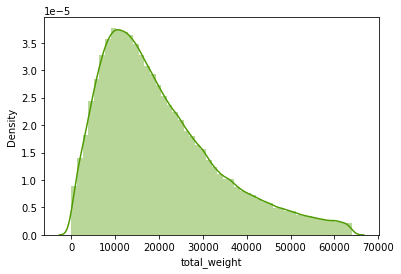

In [42]:
sns.distplot(data.query('total_weight<@weight_quantile').total_weight, color = '#4f9b02')

In [43]:
print('Суммарная стоимость корзин составила {:.2%} от первоначальной'.
      format(data.query('total_weight<@weight_quantile').item_total.sum()  / data.item_total.sum()))

Суммарная стоимость корзин составила 87.32% от первоначальной


In [44]:
data.total_cost.describe()

count    720433.000000
mean        171.820556
std         152.639804
min        -148.000000
25%          98.000000
50%         158.000000
75%         263.000000
max       30000.000000
Name: total_cost, dtype: float64

Подозрительные значения с отрицательной стоимостью доставки

In [45]:
data.query('total_cost<0')[['promo_total','cost','total_cost']]

,promo_total,cost,total_cost
236155,0.0,299.0,-99.0
348301,0.0,299.0,-148.0
585373,0.0,497.0,-99.0


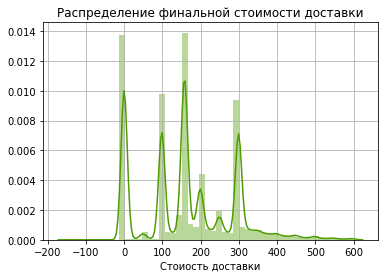

In [46]:
sns.distplot(data.query('total_cost<600').total_cost, color = '#4f9b02')
plt.title('Распределение финальной стоимости доставки')
plt.xlabel('Стоиость доставки')
plt.grid()
plt.ylabel('')
plt.show()

В среднем от создания заказа до доставки проходит 4 дня 08:20 минут. Медианно доставка происходит за 1 день 01:18 час. В среднем от заявленного интервала курьеры опаздывают на 43:15 минуты. Медианно доставка опаздывает на 50:52 минут.
Мы отфильтровали стоимость корзин по 95 персентилю веса заказа(63957.8г) и сохранили 87.32% выручки. Стоит посмотреть на сколько нагружены курьеры выполнением тяжелых заказов, можно ввести стандарт веса на курьера, также можно продлевать доставку для таких оптовых клиентов, либо просить их делать заказ заранее. Выполнение таких заказов не должно сказываться на доставке базовым пользователям. 

### Города и ритейлеры
<div id = cities_retailers></div>

топ ритейлеров

In [47]:
retailer_gb = data.groupby(['retailer_id']).agg({'user_id':['count','nunique'],
                                                 'item_total':['sum','mean']})
retailer_gb.columns = ['count_orders', 'unique_users', 'total_sum', 'total_mean']
retailer_gb

,count_orders,unique_users,total_sum,total_mean
retailer_id,,,,
1,619200,224214,3185986562,5145.327135
8,53612,29930,179163981,3341.863407
15,45348,29258,182855341,4032.269141
16,2273,1023,8181123,3599.262209


топ городов

In [48]:
city_gb = data.groupby(['city']).agg({'user_id':['count','nunique'],
                                      'item_total':['sum','mean']})
city_gb.columns = ['count_orders', 'unique_users', 'total_sum', 'total_mean']
city_gb.sort_values('count_orders', ascending = False)

,count_orders,unique_users,total_sum,total_mean
city,,,,
1,478861,176015,2633935595,5500.417856
7,76360,21819,281712395,3689.266566
10,46789,15816,181328178,3875.444613
2,39784,13948,155608511,3911.333978
5,29386,11671,115071114,3915.848159
8,28677,11600,111014967,3871.219688
13,20576,7551,77516247,3767.313715


топ магазинов

In [49]:
store_gb = data.groupby(['store_id']).agg({'user_id':['count','nunique'],
                                           'item_total':['sum','mean']})
store_gb.columns = ['count_orders', 'unique_users', 'total_sum', 'total_mean']
store_gb.sort_values('total_sum', ascending = False).head(10)

,count_orders,unique_users,total_sum,total_mean
store_id,,,,
14,57606,22103,329105867,5713.048415
2,52511,19378,294279101,5604.142008
12,47574,16103,288135542,6056.575903
1,44557,17202,254139569,5703.695693
21,40468,13180,245912733,6076.720693
8,45599,17615,243613523,5342.518981
10,41374,16824,237358863,5736.908759
11,35134,14166,196865355,5603.271902
3,32806,13518,161094025,4910.504938


Выделили топ ритейлеров, самый крупный обслуживает 224214 клиентов со средним чеком 5145 рублей. Самый мелкий 1023 клиента со средним чеком 3599 рублей. 

Выделили топ городов, в городе 1 имеем 176015 клиентов и самый высокий средний чек 5500 рублей. 


### Возвраты и замена
<div id = return_replace></div>

In [50]:
order_changed = changed_status_products.merge(data[['item_total',
                                                    'total_quantity',
                                                    'id']], right_on = 'id', left_on = 'order_id')

In [51]:
order_changed_gb = order_changed.groupby('order_id').\
                            agg({'item_id':'count',
                                 'item_total':'first',
                                 'total_quantity':'first'})
order_changed_gb['percent_change'] = order_changed_gb.item_id / order_changed_gb.total_quantity
order_changed_gb.head()

,item_id,item_total,total_quantity,percent_change
order_id,,,,
756916,7,4130,48,0.145833
756927,8,5015,39,0.205128
756934,12,4986,33,0.363636
756939,2,4237,30,0.066667
756940,3,4671,35,0.085714


In [52]:
print('В среднем при замене или отмене товаров заказа изменяем {:.2%} товаров заказа'.
                                      format(order_changed_gb.percent_change.mean()))

В среднем при замене или отмене товаров заказа изменяем inf% товаров заказа


При отмене или замене товара в заказе мы изменяем 7.96% от количества товаров, знаечение небольшое, но это может стать негативным пользовательским опытом. Основная идея в предоставлении информации о том, что товары заканчиваются, для этого необходимо договориться с магазинами об обновлении базы. Хорошо показывать клиенту предупреждение, также можно предложить ему самому выбрать продукт замены или вариант отмены товара. 

Есть вариант добавить бонусы в качестве извинений за то, что мы не смогли забрать товар, можем измерять удовлетворенность пользователей и на основании этого принимать решения. 
Также хорошо предупредить пользователя о поступлении товара, так мы сможем получить дополнительный заказ пользователя. 

### Когортный анализ
<div id = cohort_analysis></div>

In [53]:
orders = data
orders_visit = orders.groupby('user_id')['create_date'].min() 
orders_visit.name = 'first_visit'
orders = orders.join(orders_visit, on='user_id')

In [55]:
orders['visit_month'] = orders['create_date'].astype('datetime64[M]')
orders['first_visit_month'] = orders['first_visit'].astype('datetime64[M]')
orders['cohort_lifetime'] = orders['visit_month'] - orders['first_visit_month']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].apply(np.round).astype('int')

In [56]:
cohorts = orders.groupby(['first_visit_month','cohort_lifetime']).\
                                agg({'user_id':'nunique',
                                     'item_total':'mean',
                                     'promo_total':'mean',
                                     'id':'count'}).reset_index()

In [57]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 
cohorts = cohorts.rename(columns={'id':'count_order'})
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']
cohorts['discount'] = abs(cohorts.promo_total / cohorts.item_total)
cohorts['promo_total'] = cohorts['promo_total'].round(1)
cohorts['mean_orders'] = cohorts.count_order / cohorts.user_id

In [58]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m-%d')

In [59]:
count_order_pivot = cohorts.pivot_table(index='first_visit_month',
                                        columns='cohort_lifetime',
                                        values='mean_orders',
                                        aggfunc='sum')
count_order_pivot.loc['mean'] = count_order_pivot.mean(axis = 0)

In [60]:
item_pivot = cohorts.pivot_table(index='first_visit_month',
                                 columns='cohort_lifetime',
                                 values='item_total',
                                 aggfunc='sum')

In [61]:
promo_pivot = cohorts.pivot_table(index='first_visit_month',
                                  columns='cohort_lifetime',
                                  values='promo_total',
                                  aggfunc='sum')

In [62]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

In [63]:
discount_pivot = cohorts.pivot_table(index='first_visit_month',
                                     columns='cohort_lifetime',
                                     values='discount',aggfunc='sum')

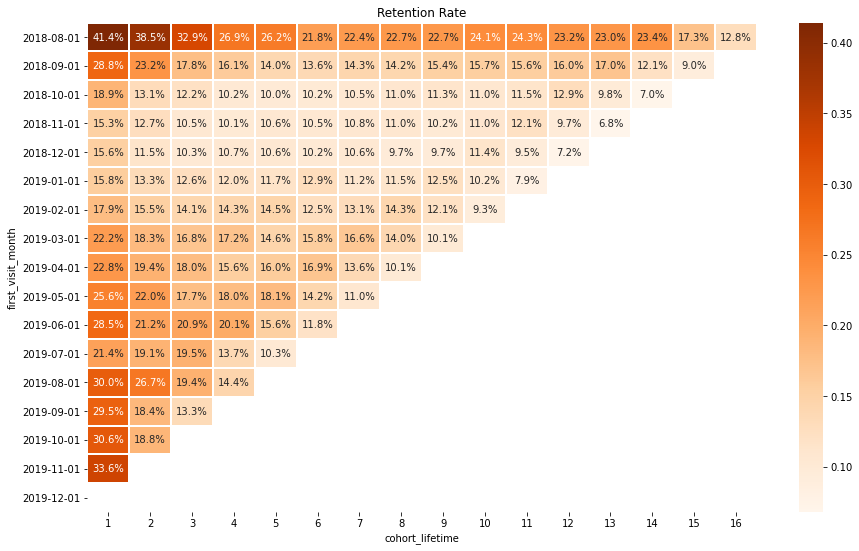

In [64]:
plt.figure(figsize=(15, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot[[i for i in range(1,17)]],
            annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="Oranges");

Можем выделить августовскую когорту, имеем в ней самые высокие коэффициенты удержания на протяжении всей жизни, 41.4% клиентов вернулись во второй месяц, спустя пол года 21.8%, спустя год 23.2%. Пользователи этой когорты лояльны к продукту, возможно, мы предоставляем им особые условия. Можем сказать, что эти значения существенно отличаются от сентябрьской-январской когорты, в дальнейшем, видимо, была изменена стратегия и уже в ноябрьской когорте 2019 года мы получили RR 33.6%

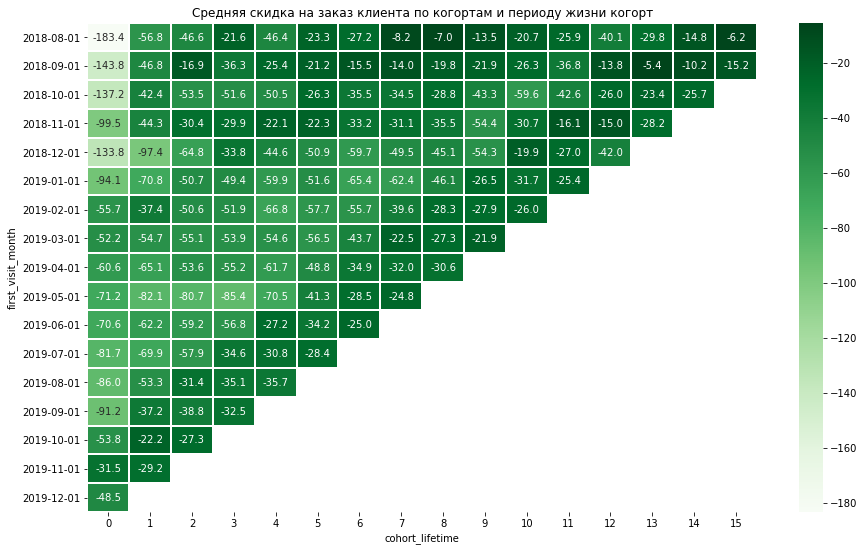

In [65]:
plt.figure(figsize=(15, 9))
plt.title('Средняя скидка на заказ клиента по когортам и периоду жизни когорт')
sns.heatmap(promo_pivot[[i for i in range(16)]],
            annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap="Greens");

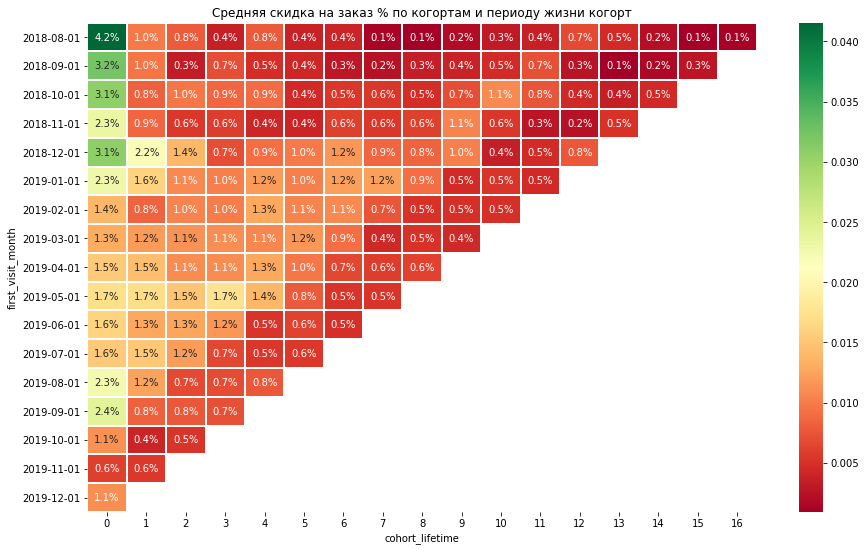

In [66]:
plt.figure(figsize=(15, 9))
plt.title('Средняя скидка на заказ % по когортам и периоду жизни когорт')
sns.heatmap(discount_pivot[[i for i in range(17)]],
            annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="RdYlGn");

Мы посмотрели средние значения скидок по когортам и их процентное соотношение с ценой заказа. Зафиксировали повышенный процент скидки у августовской, сентябрьской и октябрьской когорт 2018 года. Возможно, повышенный процент скидки и экономия пользователей стали одним из факторов их лояльности. Со второго месяца мы не предоставляем существенных скидок, однако эффект, судя по удержанию сохраняется. Интересно, что ноябрьской когорте мы в среднем предложили низкую скидку, однако имеем высокий коэффициент удержания. Вероятно, есть еще инструменты лояльности аудитории. 

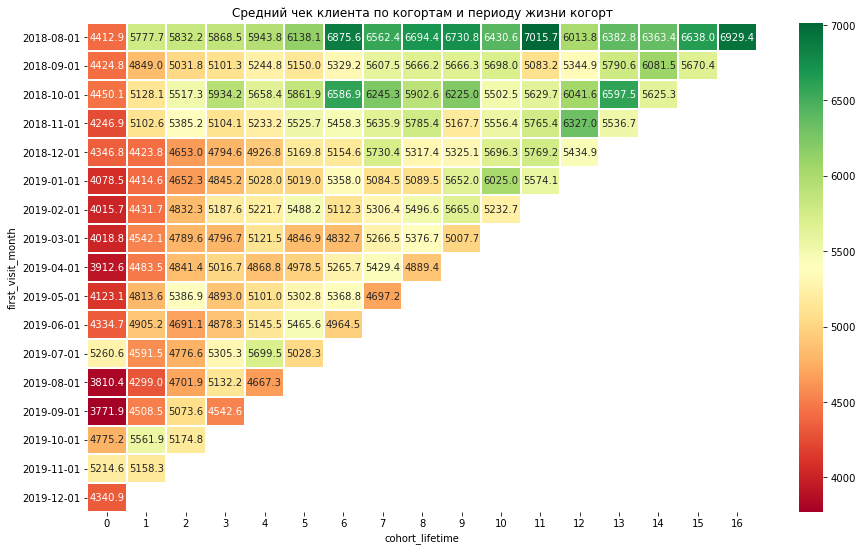

In [67]:
plt.figure(figsize=(15, 9))
plt.title('Средний чек клиента по когортам и периоду жизни когорт')
sns.heatmap(item_pivot[[i for i in range(17)]],
            annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap="RdYlGn");

Наблюдаем рост среднего чека во всех когортах на периоде жизни когорт, средний чек самой лояльной нашей когорты выбивается из остальных, имеем высокий средний чек в августовской корте 208 года. Также видим сниженный средний чек у августовской и сентябрьской когорте 2019 года и повышенный у июньской и ноябрьской 2019 года. 

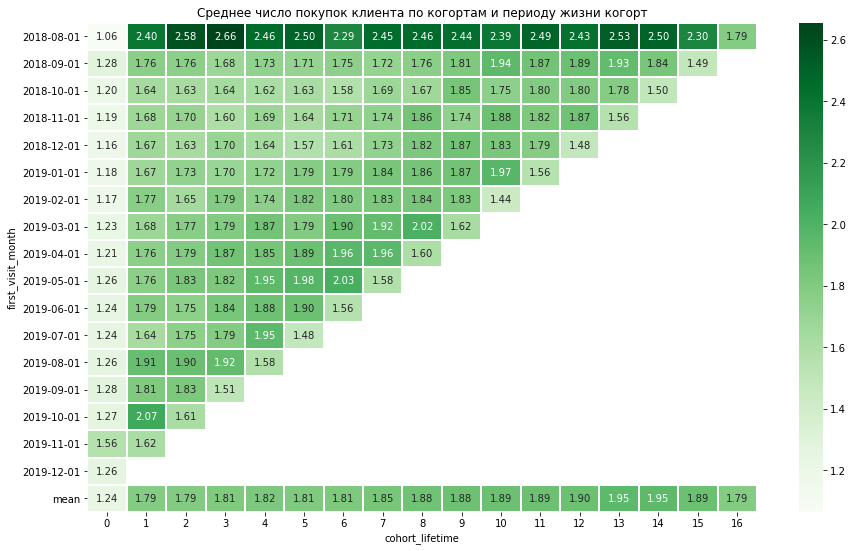

In [68]:
plt.figure(figsize=(15, 9))
plt.title('Среднее число покупок клиента по когортам и периоду жизни когорт')
sns.heatmap(count_order_pivot[[i for i in range(17)]],
            annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="Greens");

Во всех когортах наблюдаем существенное повышение среднего числа покупок во второй месяц существования и медленного повышения на всем периоде жизни когорт, лояльная когорта 2018 года показывает высокое число покупок, в среднем больше 2 каждый месяц. 

Выделяем когорту 2018-08, в ней высокий коэффициент удержания пользователя, высокий средний чек и высокое число покупок на клиента, им была предоставлена повышенная скидка в первый месяц, это могло стать причиной такой лояльности, стоит также посомтреть применение на них других инструментов повышения лояльности аудитории и попробовать сделать наших новых клиентов лояльнее сервису. 

## Презентация
<div id = presentation></div>  
    
    
### <a href = 'https://drive.google.com/file/d/1TTT7a574DcudC4srsfBuoHaddaW5zgB3/view?usp=sharing'>Ссылка на презентацию, гугл док</a>

## Выводы
<div id = conclusions></div>

Мы выгрузили данные и сформировали датасет, объединяющий таблицы заказов(orders), слотов доставок(delivery_windows), магазинов(stores) и адресов(adresses). Выгрузили отдельно логи таблиц отмены и замены товаров заказа, посмотрим как много нам приходится заменять товаров и поищем что-то общее у товаров отмены.
Будем работать с 720432 заказов и 19 параметрами. Первичный анализ показал, что типы данных соответствуют заявленным и в датасете отсутствуют полные дубли, также в данных обнаружены пропуски, 46 значений отсутствует в колонках координат доставки(lat,lon), возможно, это объясняется последующим удалением адреса доставки пользователем. 4 пропуска в колонках интервала доставки (starts_at,ends_at) могут объясняться сбоем, либо удалением из базы таких интервалов.

DAU =  1464, WAU =  9043, MAU =  27570, Наш средний чек имеет растущий тренд, но мы наблюдаем провал в августе-сентябре и дальнейший восстановительный рост. В то же время клиентов у сервиса становилось все больше, на графике мы видим снижение в последний месяц только потому, что оперируем данными только за его половину, до 18 числа.
Средний чек сервиса 4936.18. По дневному графику видно, что мы около 10 дней фиксировали низкие значенияc с минимумом среднего чека 3926.78 рублей, позже значения немного отросли и зафиксировались на уровне 4500. Трудно сказать, является ли такая особенность сезонной, так как не имеем данных за прошлый год, но это может быть следствие сбоя или это результат конкретных решений в продукте. Из того, что значения не отросли до прежних максимумов, а зафиксировались в новом интервале, можем сказать, что резульат - следствие изменений в продукте.
Предположили рост стоимости доставки, но это не подтвердилось, средняя стоимость доставки в этот период снижалась. Средний чек снижается в период выходных(с 5000 до 4800 рублей). Максимальное число заказов получаем в четверг и пятницу(108000), минимальное в среду(около 98000) и воскресенье(98000).
Число заказов сервиса стремительно растет, с сентября 2019 но ноябрб 2019 фиксируем рост 896%.

В среднем от создания заказа до доставки проходит 4 дня 08:20 минут. Медианно доставка происходит за 1 день 01:18 час. В среднем от заявленного интервала курьеры опаздывают на 43:15 минуты. Медианно доставка опаздывает на 50:52 минут. Мы отфильтровали стоимость корзин по 95 персентилю веса заказа(63957.8г) и сохранили 87.32% выручки. Стоит посмотреть на сколько нагружены курьеры выполнением тяжелых заказов, можно ввести стандарт веса на курьера, также можно продлевать доставку для таких оптовых клиентов, либо просить их делать заказ заранее. Выполнение таких заказов не должно сказываться на доставке базовым пользователям. Существует вариант редактированая аудитории сервиса путем введения базового веса доставки и числа курьеров на заказ, так станет меньше оптовых заказчиков, но наша доставка может ускориться, за счет этого можно увеличитт удовлетворенность пользвателей и обрести новых. 

По результатам когортного анализа можем выделить августовскую когорту, имеем в ней самые высокие коэффициенты удержания на протяжении всей жизни, 41.4% клиентов вернулись во второй месяц, спустя пол года 21.8%, спустя год 23.2%. Пользователи этой когорты лояльны к продукту, возможно, мы предоставляем им особые условия. Можем сказать, что эти значения существенно отличаются от сентябрьской-январской когорты, в дальнейшем, видимо, была изменена стратегия и уже в ноябрьской когорте 2019 года мы получили RR 33.6%  
Во всех когортах наблюдаем существенное повышение среднего числа покупок во второй месяц существования и медленного повышения на всем периоде жизни когорт, лояльная когорта 2018 года показывает высокое число покупок, в среднем больше 2 каждый месяц.

Выделяем когорту 2018-08, в ней высокий коэффициент удержания пользователя, высокий средний чек и высокое число покупок на клиента, им была предоставлена повышенная скидка в первый месяц, это могло стать причиной такой лояльности, стоит также посмотреть применение на них других инструментов повышения лояльности аудитории и попробовать сделать наших новых клиентов лояльнее сервису.

При отмене или замене товара в заказе мы изменяем 7.96% от количества товаров, значение небольшое, но это может стать негативным пользовательским опытом. Основная идея в предоставлении информации о том, что товары заканчиваются, для этого необходимо договориться с магазинами об обновлении базы. Хорошо показывать клиенту предупреждение, также можно предложить ему самому выбрать продукт замены или вариант отмены товара.
Есть вариант добавить бонусы в качестве извинений за то, что мы не смогли забрать товар, можем измерять удовлетворенность пользователей и на основании этого принимать решения. Также хорошо предупредить пользователя о поступлении товара, так мы сможем получить дополнительный заказ пользователя.


